In [1]:
import pandas as pd 
import numpy as np 
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

import math

import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *
from datetime import timedelta


In [2]:
df_to_forecasting = pd.read_csv(r'../data/updated_data_ind/avax_ind.csv')

In [3]:
df_avax = pd.read_csv(r'../data/cryptoInd/avax_ind.csv')
close = df_avax['close']
df_avax.drop('close', axis = 1, inplace = True)
df_avax['close'] = close

close = df_to_forecasting['close']
df_to_forecasting.drop('close', axis = 1, inplace = True)
df_to_forecasting['close'] = close

In [4]:
df_avax.head(10)

,Date,adj_close,low,high,open,volume,SMA30,CMA30,EMA30,adx,...,macd,macdsignal,macdhist,rsi,stdev,slowk,slowd,dollar_close,sp500_close,close
0,2020-10-23,4.262106,4.149672,4.486894,4.330929,19482074.0,4.152443,4.222485,4.135910,49.993793,...,-0.096510,-0.165741,0.069231,49.152537,0.169385,64.584082,49.262333,92.764999,3465.389893,4.262106
1,2020-10-24,4.189700,4.161980,4.352660,4.262106,16681037.0,4.149402,4.221549,4.142634,49.450977,...,-0.081553,-0.148904,0.067350,47.896180,0.168276,69.038435,60.137230,92.764999,3465.389893,4.189700
2,2020-10-25,4.153210,4.105395,4.257972,4.189700,15517939.0,4.157836,4.219650,4.143956,48.793687,...,-0.071816,-0.133486,0.061670,47.244135,0.165054,60.514779,64.712432,92.764999,3465.389893,4.153210
3,2020-10-26,4.160973,4.049678,4.479071,4.153210,9243755.0,4.162176,4.218065,4.146083,48.432024,...,-0.062750,-0.119339,0.056589,47.407334,0.164222,49.584064,59.712426,93.043999,3400.969971,4.160973
4,2020-10-27,4.122243,4.043659,4.349709,4.160973,17600881.0,4.142609,4.215543,4.143103,48.077074,...,-0.058021,-0.107076,0.049054,46.636153,0.149686,35.276057,48.458300,92.927002,3390.679932,4.122243
5,2020-10-28,4.066606,3.935027,4.177805,4.122243,19435211.0,4.114513,4.211724,4.133541,47.421360,...,-0.058094,-0.097279,0.039186,45.497029,0.118517,26.338603,37.066241,93.408997,3271.030029,4.066606
6,2020-10-29,3.775312,3.733383,4.106396,4.066606,6527859.0,4.089530,4.200814,4.088762,46.225565,...,-0.080725,-0.093968,0.013243,40.014316,0.144942,15.845942,25.820201,93.976997,3310.110107,3.775312
7,2020-10-30,3.714938,3.580127,3.819172,3.775312,28434550.0,4.062035,4.188963,4.042034,44.686050,...,-0.102353,-0.095645,-0.006707,38.971421,0.171789,14.934941,19.039829,94.042000,3269.959961,3.714938
8,2020-10-31,3.648368,3.585136,3.743536,3.714938,20452535.0,4.035895,4.176092,3.992826,43.249169,...,-0.123441,-0.101204,-0.022237,37.807315,0.200513,9.828904,13.536596,94.042000,3269.959961,3.648368
9,2020-11-01,3.682664,3.555984,3.716676,3.648368,15953277.0,4.001672,4.164617,3.954056,41.821084,...,-0.135821,-0.108128,-0.027693,38.816130,0.213643,14.745420,13.169755,94.042000,3269.959961,3.682664


In [5]:
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=df_avax['Date'], y=df_avax['close'], name='BITCOIN', mode='lines',line=dict(color='red')))
fig2.show()

In [6]:
inicial_date = '2021-08-22'
df_avax['Date'] = pd.to_datetime(df_avax['Date'])
df_to_forecasting['Date'] = pd.to_datetime(df_to_forecasting['Date'])
inicial_date = pd.to_datetime(inicial_date)
df_avax = df_avax[df_avax['Date'] >= inicial_date]
df_to_forecasting = df_to_forecasting[df_to_forecasting['Date'] >= inicial_date]

# Scaling

In [7]:
df_avax.set_index('Date', inplace=True)
scaled_df = df_avax.copy()
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df_avax)
scaled_df = pd.DataFrame(scaled_feat, index = df_avax.index, columns=df_avax.columns)
scaled_df.head()

,adj_close,low,high,open,volume,SMA30,CMA30,EMA30,adx,bb_low,...,macd,macdsignal,macdhist,rsi,stdev,slowk,slowd,dollar_close,sp500_close,close
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-22,0.066484,0.085230,0.052215,0.072777,0.282731,0.000000,0.000000,0.000000,0.800109,0.008789,...,0.674122,0.590754,0.888576,0.970492,0.554425,0.900557,0.980165,0.151500,0.432956,0.066484
2021-08-23,0.096421,0.115957,0.127720,0.071726,0.400627,0.022497,0.003331,0.027439,0.849578,0.009056,...,0.708743,0.625985,0.900391,0.979823,0.628685,0.801666,0.921144,0.096344,0.493448,0.096421
2021-08-24,0.187675,0.123282,0.183122,0.101101,0.634199,0.050313,0.007621,0.064372,0.896748,0.000000,...,0.761660,0.666453,0.950383,1.000000,0.753310,0.827261,0.888378,0.089154,0.504154,0.187675
2021-08-25,0.092981,0.138227,0.168591,0.193232,0.405066,0.071409,0.010873,0.083276,0.940774,0.016382,...,0.768405,0.700392,0.888067,0.685905,0.766538,0.688995,0.809534,0.082067,0.520068,0.092981
2021-08-26,0.044823,0.092295,0.084541,0.098461,0.295132,0.088954,0.013594,0.092998,0.955107,0.040461,...,0.753892,0.724176,0.791105,0.567415,0.740980,0.438473,0.674179,0.107334,0.478222,0.044823


# Correlation Matrix

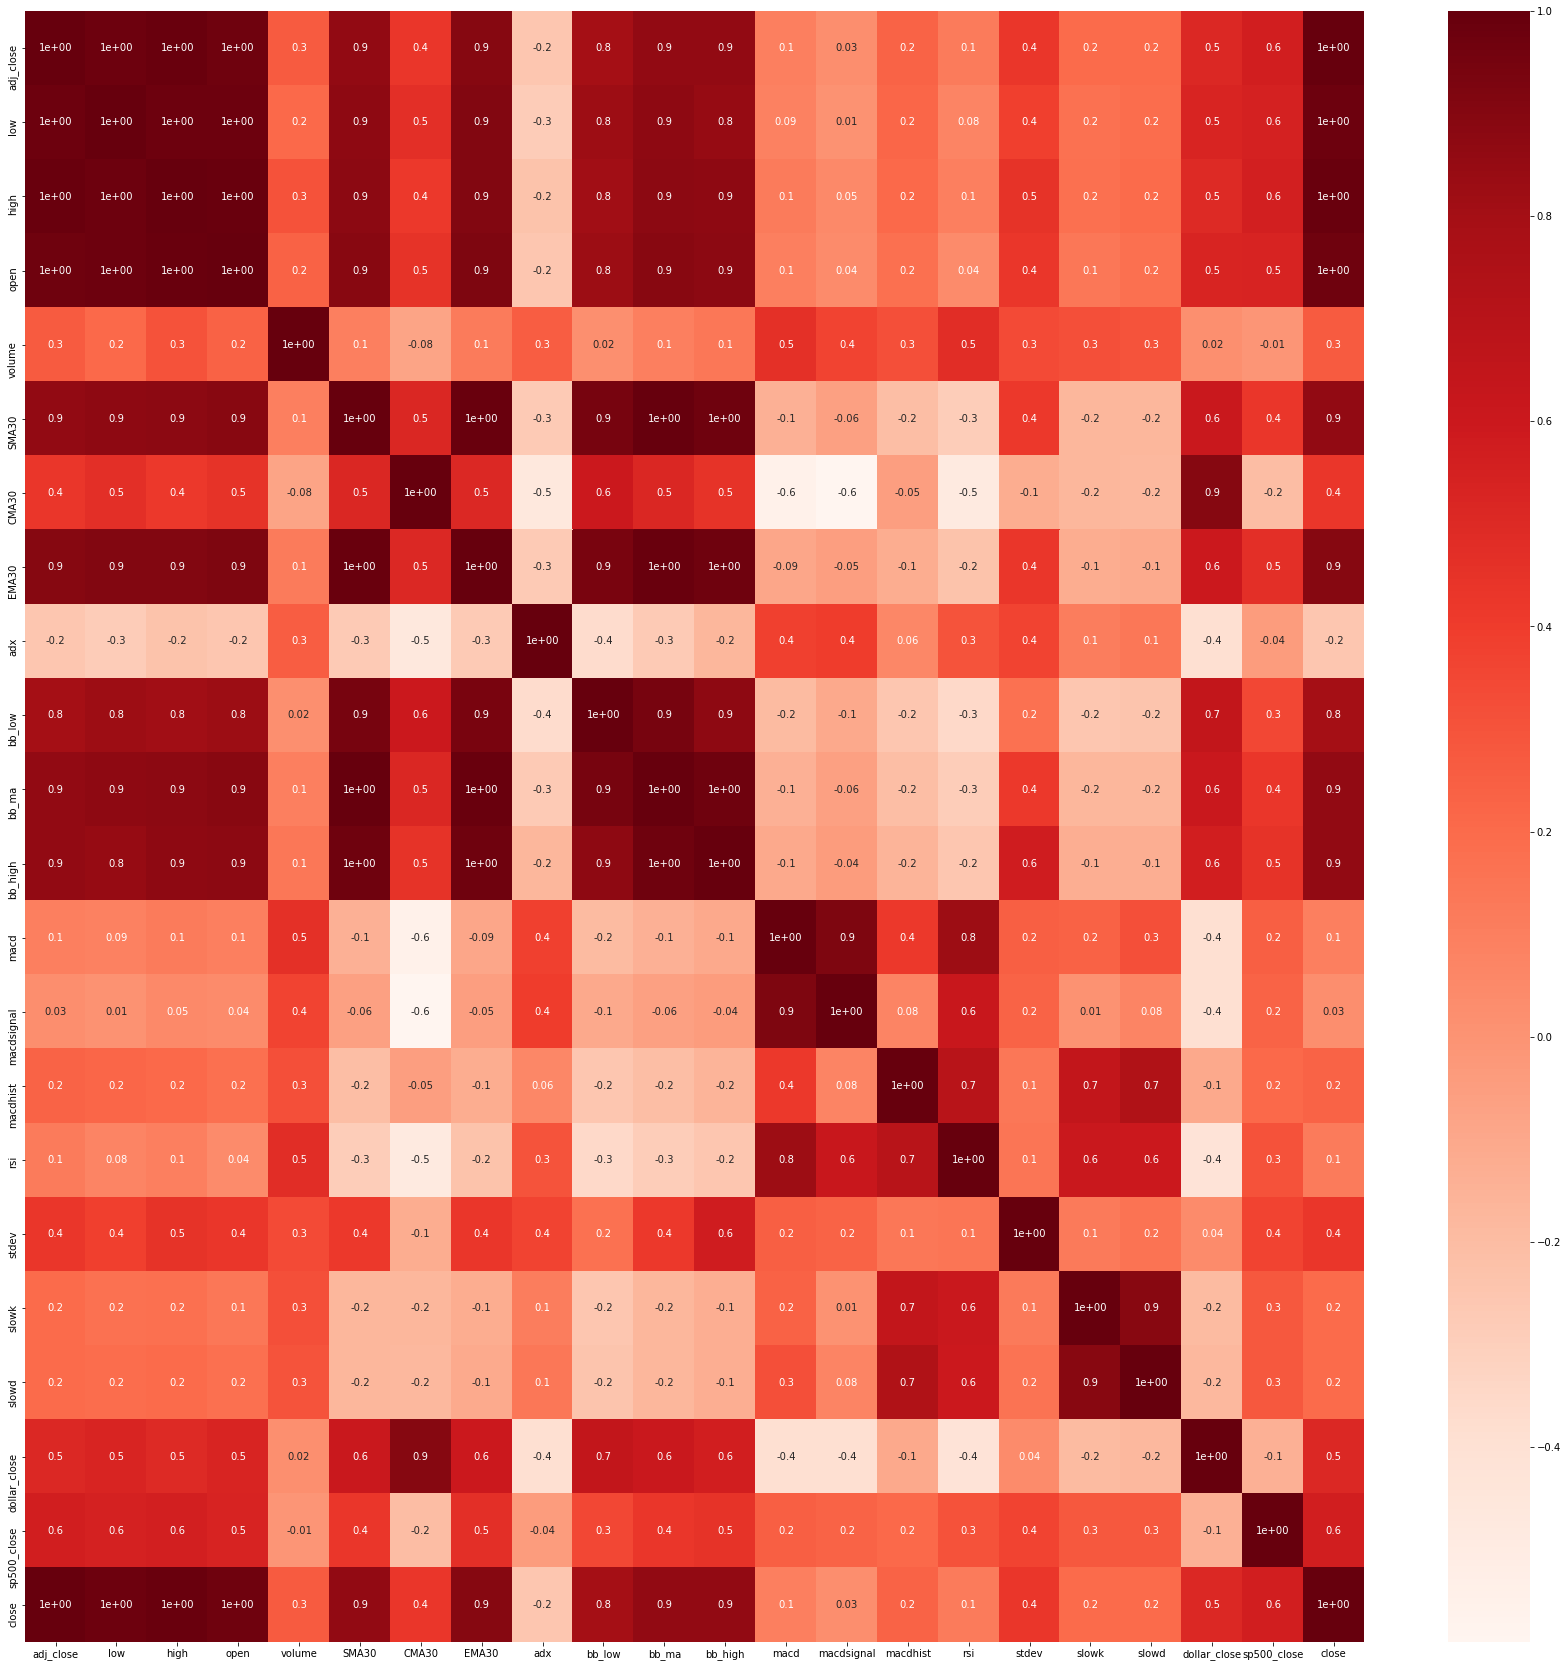

In [8]:
#Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(scaled_df.corr(method="spearman"), decimals=2)

def cor_heatmap(cor):
    plt.figure(figsize=(30,30))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()


cor_heatmap(corr)

In [9]:
scaled_df.columns

Index(['adj_close', 'low', 'high', 'open', 'volume', 'SMA30', 'CMA30', 'EMA30',
       'adx', 'bb_low', 'bb_ma', 'bb_high', 'macd', 'macdsignal', 'macdhist',
       'rsi', 'stdev', 'slowk', 'slowd', 'dollar_close', 'sp500_close',
       'close'],
      dtype='object')

In [10]:
df_avax.drop(['low', 'adj_close', 'open','EMA30','SMA30',
 'bb_ma', 'bb_high'], axis=1, inplace=True)

df_to_forecasting.drop(['low', 'adj_close', 'open','EMA30','SMA30',
 'bb_ma', 'bb_high'], axis=1, inplace=True)

## TimeBaseCV

In [11]:
import pandas as pd
import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *

# code from: https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8"

class TimeBasedCV(object):
    '''
    Parameters 
    ----------
    train_period: int
        number of time units to include in each train set
        default is 30
    test_period: int
        number of time units to include in each test set
        default is 7
    freq: string
        frequency of input parameters. possible values are: days, months, years, weeks, hours, minutes, seconds
        possible values designed to be used by dateutil.relativedelta class
        deafault is days
    '''
    
    
    def __init__(self, train_period=30, test_period=7, freq='days'):
        self.train_period = train_period
        self.test_period = test_period
        self.freq = freq

        
        
    def split(self, data, validation_split_date=None, date_column='record_date', gap=0):
        '''
        Generate indices to split data into training and test set
        
        Parameters 
        ----------
        data: pandas DataFrame
            your data, contain one column for the record date 
        validation_split_date: datetime.date()
            first date to perform the splitting on.
            if not provided will set to be the minimum date in the data after the first training set
        date_column: string, deafult='record_date'
            date of each record
        gap: int, default=0
            for cases the test set does not come right after the train set,
            *gap* days are left between train and test sets
        
        Returns 
        -------
        train_index ,test_index: 
            list of tuples (train index, test index) similar to sklearn model selection
        '''
        
        # check that date_column exist in the data:
        try:
            data[date_column]
        except:
            raise KeyError(date_column)
                    
        train_indices_list = []
        test_indices_list = []

        if validation_split_date==None:
            validation_split_date = data[date_column].min().date() + eval('relativedelta('+self.freq+'=self.train_period)')
        
        start_train = validation_split_date - eval('relativedelta('+self.freq+'=self.train_period)')
        end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
        start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
        end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        while end_test < data[date_column].max().date():
            # train indices:
            cur_train_indices = list(data[(data[date_column].dt.date>=start_train) & 
                                     (data[date_column].dt.date<end_train)].index)

            # test indices:
            cur_test_indices = list(data[(data[date_column].dt.date>=start_test) &
                                    (data[date_column].dt.date<end_test)].index)
            
            #print("Train period:",start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
            #      "# train records", len(cur_train_indices), ", # test records", len(cur_test_indices))

            train_indices_list.append(cur_train_indices)
            test_indices_list.append(cur_test_indices)

            # update dates:
            start_train = start_train + eval('relativedelta('+self.freq+'=self.test_period)')
            end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
            start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
            end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        # mimic sklearn output  
        index_output = [(train,test) for train,test in zip(train_indices_list,test_indices_list)]

        self.n_splits = len(index_output)
        
        return index_output
    
    
    def get_n_splits(self):
        """Returns the number of splitting iterations in the cross-validator
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return self.n_splits

# Models

## Function to Apply the Models

In [12]:
def add_days(df, forecast_length):
    end_point = len(df)
    df1 = pd.DataFrame(index=range(forecast_length), columns=range(2))
    df1.columns = ['close', 'Date']
    df = df.append(df1)
    df = df.reset_index(drop=True)
    x = df.at[end_point - 1, 'Date']
    x = pd.to_datetime(x, format='%Y-%m-%d')
    for i in range(forecast_length):
        df.at[df.index[end_point + i], 'Date'] = x + timedelta(days=1+i)
        df.at[df.index[end_point + i], 'close'] = 0
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df = df.drop(['Date'], axis=1)
    return df

In [13]:
def forecasting(model,df1, forecast_length):
    df3 = df1[['close', 'Date']]
    df3 = add_days(df3, forecast_length)
    finaldf = df1.drop('Date', axis=1)
    finaldf = finaldf.reset_index(drop=True)
    end_point = len(finaldf)
    x = end_point - forecast_length
    finaldf_train = finaldf.loc[:x - 1, :]
    finaldf_train_x = finaldf_train.loc[:, finaldf_train.columns != 'close']
    finaldf_train_y = finaldf_train['close']

    fit = model.fit(finaldf_train_x, finaldf_train_y)
    yhat = []
    end_point = len(finaldf)
    df3_end = len(df3)
    for i in range(forecast_length, 0, -1):
        y = end_point - i
        inputfile = finaldf.loc[y:end_point, :]
        inputfile_x = inputfile.loc[:, inputfile.columns != 'close']
        pred_set = inputfile_x.head(1)
        pred = fit.predict(pred_set)
        df3.at[df3.index[df3_end - i], 'close'] = pred[0]
        finaldf = df1.drop('Date', axis=1)
        finaldf = finaldf.reset_index(drop=True)
        yhat.append(pred)
    yhat = np.array(yhat)
    return yhat

In [14]:
def show_results(df_results, df,objetive,train_period_split,test_period_split, *args):
    #Scalling
    scaler = MinMaxScaler()
    scaled_feat = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_feat, index = df.index, columns=df.columns)

    X_scaled = scaled_df.drop(objetive, axis=1)
    y_scaled = scaled_df[objetive]

    X_tbcv = X_scaled.reset_index()
    y_scaled = y_scaled.reset_index()
    y_scaled['Date'] = pd.to_datetime(y_scaled['Date'], format='%Y-%m-%d')   
    X_tbcv['Date'] = pd.to_datetime(X_tbcv['Date'], format='%Y-%m-%d')                
    tscv = TimeBasedCV(train_period=train_period_split,
        test_period=test_period_split,
        freq='days')
    colours =['red', 'blue', 'yellow', 'pink']
    fig2 = go.Figure()
    count = 0
    for idx,arg in enumerate(args):
        for train_index, test_index in tscv.split(X_tbcv,date_column='Date'):
            X_train = X_tbcv.loc[train_index]
            y_train = y_scaled.loc[train_index]
            X_train['close'] = y_train['close']
            y_test  = y_scaled.loc[test_index]
            X_test = X_tbcv.loc[test_index]
            X_test.set_index('Date', inplace=True)
            y_test.set_index('Date', inplace=True)
            mae_list = []
            mse_list = []
            r2_list = []
            rmse_list = []
            y_pred_test = forecasting(model=arg,df1=X_train,forecast_length=test_period_split)
            # prints metric results         
            value_mae = mean_absolute_error(y_test, y_pred_test)
            value_mse = mean_squared_error(y_test, y_pred_test)
            value_r2 = r2_score(y_test, y_pred_test)
            value_rmse = math.sqrt(value_mse)
            #print(value_mae, value_mse, value_r2)
            # append the accuracies, the time and the number of iterations in the corresponding list
            mae_list.append(value_mae)
            mse_list.append(value_mse)
            r2_list.append(value_r2)
            rmse_list.append(value_rmse)

            real_name = 'real '+ str(X_test.index.min().day)+"-"+ str(X_test.index.min().month)+"-"+ str(X_test.index.min().year)+" to "\
                + str(X_test.index.max().day)+"-"+ str(X_test.index.max().month)+"-"+ str(X_test.index.max().year)
            pred_name = 'pred '+ str(X_test.index.min().day)+"-"+ str(X_test.index.min().month)+"-"+ str(X_test.index.min().year)+" to"\
                + str(X_test.index.max().day)+"-"+ str(X_test.index.max().month)+"-"+ str(X_test.index.max().year)
            X_train['close'] = y_train['close']
            X_pred_test = X_test.copy()
            X_test['close'] = y_test['close']
            X_pred_test['close'] = y_pred_test
            X_pred_test_undo = scaler.inverse_transform(X_pred_test)
            X_test_undo = scaler.inverse_transform(X_test)

            X_pred_test_graphic = pd.DataFrame(data = X_pred_test_undo, index = X_pred_test.index, columns=X_pred_test.columns)
            X_test_graphic = pd.DataFrame(data =X_test_undo, index = X_test.index, columns=X_test.columns)

            fig2.add_trace(go.Scatter(x=X_test_graphic.index, y=X_test_graphic['close'], name=real_name, mode='lines',line=dict(color='green')))
            fig2.add_trace(go.Scatter(x=X_pred_test_graphic.index, y=X_pred_test_graphic['close'], name=pred_name, mode='lines', line=dict(color=colours[idx])))

        fig2.update_layout(dict(updatemenus=[
                                dict(
                                type = "buttons",
                                direction = "left",
                                buttons=list([
                                        dict(
                                        args=["visible", "legendonly"],
                                        label="Deselect All",
                                        method="restyle"
                                        ),
                                        dict(
                                        args=["visible", True],
                                        label="Select All",
                                        method="restyle"
                                        )
                                ]),
                                pad={"r": 10, "t": 10},
                                showactive=False,
                                x=1,
                                xanchor="right",
                                y=1.1,
                                yanchor="top"
                                ),
                        ]
                ))
        mae = round(np.mean(mae_list),10)
        mse = round(np.mean(mse_list),10)
        r2 = round(np.mean(r2_list),10)
        rmse = round(np.mean(rmse_list),10)
        df_results.iloc[count] = mae, mse,rmse, r2
        count+=1
    fig2.show()
    return df_results
        
    

## Random Forest

In [15]:
rf_se = RandomForestRegressor(random_state=10,criterion='mse')
rf_ae = RandomForestRegressor(random_state=10,criterion='mae')
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE','R2'], index = ['mse','mae'])
show_results(df, df_avax,'close',100,5, rf_se, rf_ae)

,MAE,MSE,RMSE,R2
mse,0.027324,0.001104,0.03323,-0.406468
mae,0.02454,0.000937,0.030614,-0.193729


In [16]:
rf_5 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=5)
rf_20 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=20)
rf_50 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=50)
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['5','20', '50'])
show_results(df, df_avax,'close',100,5,rf_5, rf_20,rf_50)

,MAE,MSE,RMSE,R2
5,0.028663,0.001201,0.034653,-0.52946
20,0.02454,0.000937,0.030614,-0.193729
50,0.02454,0.000937,0.030614,-0.193729


In [17]:
rf_auto = RandomForestRegressor(random_state=10,criterion='mae', max_depth=20, max_features='auto')
rf_sqrt = RandomForestRegressor(random_state=10,criterion='mae', max_depth=20, max_features='sqrt')
rf_log2 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=20,max_features='log2' )
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['auto','sqrt', 'log2'])
show_results(df, df_avax,'close',100,5,rf_auto, rf_sqrt,rf_log2)

,MAE,MSE,RMSE,R2
auto,0.02454,0.000937,0.030614,-0.193729
sqrt,0.026569,0.000789,0.028088,-0.00483
log2,0.026569,0.000789,0.028088,-0.00483


In [18]:
rf_10 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=20, max_features='sqrt', n_estimators=50)
rf_20 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=20, max_features='sqrt',n_estimators=100)
rf_30 = RandomForestRegressor(random_state=10,criterion='mae', max_depth=20,max_features='sqrt', n_estimators=150)
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['50','100', '150'])
show_results(df, df_avax,'close',100,5,rf_10, rf_20,rf_30)

,MAE,MSE,RMSE,R2
50,0.02505,0.000684,0.026162,0.128226
100,0.026569,0.000789,0.028088,-0.00483
150,0.024201,0.000726,0.026941,0.075516


In [19]:
rf_final = RandomForestRegressor(random_state=10,criterion='mae', max_depth=20, max_features='sqrt', n_estimators=50)
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['final'])
show_results(df, df_avax,'close',100,5, rf_final)

,MAE,MSE,RMSE,R2
final,0.02505,0.000684,0.026162,0.128226


## Gradient Boost

In [20]:
gb_mae = GradientBoostingRegressor(random_state = 10 , criterion='mae')
gb_mse = GradientBoostingRegressor(random_state = 10 , criterion='mse')

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE','R2'], index = ['mae','mse'])
show_results(df, df_avax,'close',100,5,gb_mae, gb_mse)

,MAE,MSE,RMSE,R2
mae,0.019715,0.000613,0.024768,0.218656
mse,0.021617,0.000768,0.027719,0.021417


In [24]:
gb_50 = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 450)
gb_100 = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 500)
gb_150 = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 550)
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE','R2'], index = ['450','500', '550'])
show_results(df, df_avax,'close',100,5,gb_50, gb_100, gb_150)

,MAE,MSE,RMSE,R2
450,0.018828,0.000582,0.024118,0.259142
500,0.018815,0.000581,0.024098,0.26039
550,0.018817,0.000581,0.024095,0.260527


In [25]:
gb_auto = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 550, max_features=  'auto' )
gb_sqrt = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 550, max_features = 'sqrt')
gb_log2 = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 550, max_features=  'log2')
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE','R2'], index = ['auto','sqrt', 'log2'])
show_results(df, df_avax,'close',100,5,gb_auto, gb_sqrt, gb_log2)

,MAE,MSE,RMSE,R2
auto,0.018817,0.000581,0.024095,0.260527
sqrt,0.022927,0.000649,0.025482,0.172955
log2,0.022927,0.000649,0.025482,0.172955


In [26]:
gb_final = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 550, max_features=  'auto')
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE','R2'], index = ['final'])
show_results(df, df_avax,'close',100,5,gb_final)

,MAE,MSE,RMSE,R2
final,0.018817,0.000581,0.024095,0.260527


## Neural Nerworks

In [28]:
nn_2525 = MLPRegressor(hidden_layer_sizes=(10), random_state=15,max_iter = 3000)
nn_10101010 = MLPRegressor(hidden_layer_sizes=(20), random_state=15,max_iter = 3000)
nn_10 = MLPRegressor(hidden_layer_sizes=(30), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE','R2'], index = ['10','20', '30'])
show_results(df, df_avax,'close',100,5,nn_2525, nn_10101010, nn_10)

,MAE,MSE,RMSE,R2
10,0.056832,0.004044,0.063593,-4.150809
20,0.067347,0.006071,0.077917,-6.732503
30,0.110127,0.012673,0.112574,-15.141166


In [29]:
nn_identity = MLPRegressor(activation = 'identity',hidden_layer_sizes=(10), random_state=15,max_iter = 3000)
nn_logistic = MLPRegressor(activation = 'logistic',hidden_layer_sizes=(10), random_state=15,max_iter = 3000)
nn_tanh = MLPRegressor(activation = 'tanh',hidden_layer_sizes=(10), random_state=15,max_iter = 3000)
nn_relu = MLPRegressor(activation = 'relu',hidden_layer_sizes=(10), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE','R2'], index = ['identity','logistic', 'tanh', 'relu'])
show_results(df, df_avax,'close',100,5,nn_identity, nn_logistic, nn_tanh, nn_relu)

,MAE,MSE,RMSE,R2
identity,0.075743,0.011671,0.108034,-13.865361
logistic,0.050828,0.003558,0.059646,-3.531236
tanh,0.069847,0.009538,0.097665,-11.148795
relu,0.056832,0.004044,0.063593,-4.150809


In [30]:
nn_lbfgs = MLPRegressor(solver = 'lbfgs', activation = 'relu',hidden_layer_sizes=(10), random_state=15,max_iter = 3000)
nn_sgd = MLPRegressor(solver = 'sgd', activation = 'relu',hidden_layer_sizes=(10), random_state=15,max_iter = 3000)
nn_adam = MLPRegressor(solver = 'adam', activation = 'relu',hidden_layer_sizes=(10), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE','R2'], index = ['lbfgs','sgd', 'adam'])
show_results(df, df_avax,'close',100,5,nn_lbfgs, nn_sgd, nn_adam)

,MAE,MSE,RMSE,R2
lbfgs,0.022711,0.000639,0.025288,0.185524
sgd,0.04269,0.002276,0.04771,-1.899134
adam,0.056832,0.004044,0.063593,-4.150809


In [31]:
nn_constant = MLPRegressor(learning_rate = 'constant',solver = 'lbfgs', activation = 'relu',
hidden_layer_sizes=(10), random_state=15,max_iter = 3000)
nn_invscaling = MLPRegressor(learning_rate = 'invscaling',solver = 'lbfgs', activation = 'relu',
hidden_layer_sizes=(10), random_state=15,max_iter = 3000)
nn_adaptive = MLPRegressor(learning_rate = 'adaptive',solver = 'lbfgs', activation = 'relu',
hidden_layer_sizes=(10), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE','R2'], index = ['constant','invscaling', 'adaptive'])
show_results(df, df_avax,'close',100,5,nn_constant, nn_invscaling, nn_adam)

,MAE,MSE,RMSE,R2
constant,0.022711,0.000639,0.025288,0.185524
invscaling,0.022711,0.000639,0.025288,0.185524
adaptive,0.056832,0.004044,0.063593,-4.150809


In [32]:
nn_final = MLPRegressor(learning_rate = 'constant',solver = 'lbfgs', activation = 'relu',hidden_layer_sizes=(10), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE','R2'], index = ['final'])
show_results(df, df_avax,'close',100,5,nn_final)

,MAE,MSE,RMSE,R2
final,0.022711,0.000639,0.025288,0.185524


## XGBoost

In [33]:
xgb_mae = XGBRegressor(random_state = 10 , criterion='absolute_error')
xgb_mse = XGBRegressor(random_state = 10 , criterion='squared_error')

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['mae','mse'])
show_results(df, df_avax,'close',100,5,xgb_mae, xgb_mse)

[16:21:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:21:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:21:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.

,MAE,MSE,RMSE,R2
mae,0.034209,0.001711,0.041358,-1.178616
mse,0.034209,0.001711,0.041358,-1.178616


In [34]:
xgb_150 = XGBRegressor(random_state = 10 , n_estimators=150)
xgb_200 = XGBRegressor(random_state = 10 , n_estimators=200)
xgb_250 = XGBRegressor(random_state = 10 , n_estimators=250)

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['150','200','250'])
show_results(df, df_avax,'close',100,5,xgb_150, xgb_200,xgb_250)

,MAE,MSE,RMSE,R2
150,0.034209,0.001711,0.041358,-1.178616
200,0.034209,0.001711,0.041358,-1.178616
250,0.034209,0.001711,0.041358,-1.178616


In [35]:
xgb_gbtree = XGBRegressor(random_state = 10 , booster= 'gbtree', n_estimators = 130)
xgb_gblinear = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130)
xgb_dart = XGBRegressor(random_state = 10 , booster= 'dart', n_estimators = 130)
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['gbtree','gblinear','dart'])

show_results(df, df_avax,'close',100,5,xgb_gbtree, xgb_gblinear,xgb_dart )

,MAE,MSE,RMSE,R2
gbtree,0.034209,0.001711,0.041358,-1.178616
gblinear,0.017918,0.000563,0.023718,0.283509
dart,0.034209,0.001711,0.041358,-1.178615


In [36]:
xgb_true = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = True)
xgb_false = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False)

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['True','False'])
show_results(df, df_avax,'close',100,5,xgb_true, xgb_false)

,MAE,MSE,RMSE,R2
True,0.01828,0.000605,0.024597,0.229404
False,0.017135,0.0005,0.02236,0.363182


In [37]:
xgb_false = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=False)
xgb_true = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=True)

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['True','False'])
show_results(df, df_avax,'close',100,5,xgb_true, xgb_false)

,MAE,MSE,RMSE,R2
True,0.017465,0.00055,0.023451,0.299522
False,0.018689,0.000635,0.025197,0.191338


In [38]:
xgb_005 = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=True,eta = 0.05)
xgb_01 = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=True,eta = 0.1)
xgb_03 = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=True,eta = 0.3)
xgb_05 = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=True,eta = 0.5)

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['0,05', '0,1', '0,3', '0,5'])
show_results(df, df_avax,'close',100,5, xgb_005,xgb_01, xgb_03, xgb_05 )

,MAE,MSE,RMSE,R2
"0,05",0.017545,0.000554,0.02353,0.294801
"0,1",0.017647,0.000556,0.023586,0.291457
"0,3",0.017639,0.00055,0.023459,0.299068
"0,5",0.017735,0.000552,0.0235,0.296595


In [39]:
xgb_final = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=True,eta = 0.3)

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['final'])
show_results(df, df_avax,'close',100,5, xgb_final)

,MAE,MSE,RMSE,R2
final,0.017927,0.000562,0.023711,0.283931


# Results

In [43]:
forecasting(xgb_final,df_to_forecasting,1)

array([[51.84382]], dtype=float32)